# Preparation

In [365]:
from itertools import product
from glob import iglob
import pandas as pd
import numpy as np
import json
import os
import re

%matplotlib inline
import matplotlib
from matplotlib import pylab as plt
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)

In [366]:
# files and formats
DIR = '../data/run/'
FILES = iglob(os.path.join(DIR, '*.json'))
RES_PAT = re.compile('air_cargo_problem_(\d+)-(\w+)-(\w+)')
COLUMNS = ['problem', 'search', 'algorithm', 'heuristic', 'plan_length', 'new_nodes', 'runtime', 'plan']

# problems and searches
PROBLEMS = ['1', '2', '3']

SEARCHES = [
    ["breadth_first_search", "uninformed"],
    ['breadth_first_tree_search', "uninformed"],
    ['depth_first_graph_search', "uninformed"],
    ['depth_limited_search', "uninformed"],
    ['uniform_cost_search', "uninformed"],
    ['recursive_best_first_search', 'h_1'],
    ['greedy_best_first_graph_search', 'h_1'],
    ['astar_search', 'h_1'],
    ['astar_search', 'h_ignore_preconditions'],
    ['astar_search', 'h_pg_levelsum'],
]

def sname(algo, heur):
    """Format an algorithm and heuristic to a search name."""
    return "{} - {}".format(algo, heur).replace('_', ' ')


RESULTS = list()

# import results
for f in FILES:
    file, ext = os.path.splitext(f) 
    filename = os.path.basename(file)
    match = RES_PAT.match(filename)
    
    if match is None:
        raise ValueError("Match failed for: {}".format(filename))
        
    prob, algo, heur = match.groups()
    uninformed = heur == 'uninformed'
    
    with open(f, 'r') as r:
        res = json.load(r)
    
    res['problem'] = prob
    res['algorithm'] = algo
    res['heuristic'] = heur
    res['uninformed'] = uninformed
    res['search'] = sname(algo, heur)
    
    RESULTS.append(res)

# create a dataframe from results
df = pd.DataFrame(RESULTS, columns=COLUMNS).sort_values(['problem', 'heuristic'])

# Visualization

## Overview

In [367]:
df.drop(['plan', 'algorithm', 'heuristic'], axis=1)

,problem,search,plan_length,new_nodes,runtime
12,1,greedy best first graph search - h 1,6,28,0.010160
14,1,astar search - h 1,6,224,0.118958
24,1,recursive best first search - h 1,6,17023,4.504784
19,1,astar search - h ignore preconditions,6,170,0.076575
9,1,astar search - h pg levelsum,6,50,2.318600
1,1,depth first graph search - uninformed,20,84,0.021924
2,1,breadth first tree search - uninformed,6,5960,1.592876
11,1,depth limited search - uninformed,50,414,0.146723
15,1,uniform cost search - uninformed,6,224,0.049170
17,1,breadth first search - uninformed,6,180,0.024268


## Completeness

In [368]:
def is_complete(df, p, a, h):
    return ((df['problem'] == p) & (df['algorithm'] == a) & (df['heuristic'] == h)).any()


COMPLETES = list()

for p, s in product(PROBLEMS, SEARCHES):
    a, h = s
    
    doc = {
        'problem': p,
        'search': sname(a, h),
        'complete': 1 if is_complete(df, p, a, h) else 0
    }
    
    COMPLETES.append(doc)
    
complete = pd.DataFrame(COMPLETES, columns=['problem', 'search', 'complete']) \
             .sort_values('problem')

In [388]:
complete

,problem,search,complete
0,1,breadth first search - uninformed,1
1,1,breadth first tree search - uninformed,1
2,1,depth first graph search - uninformed,1
3,1,depth limited search - uninformed,1
4,1,uniform cost search - uninformed,1
5,1,recursive best first search - h 1,1
6,1,greedy best first graph search - h 1,1
7,1,astar search - h 1,1
8,1,astar search - h ignore preconditions,1
9,1,astar search - h pg levelsum,1


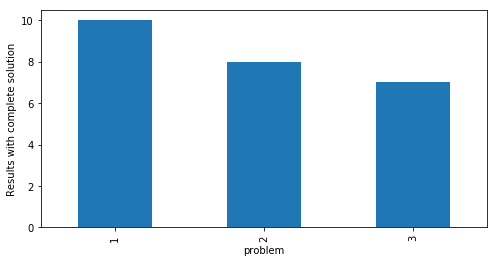

In [370]:
ax = complete.groupby('problem').sum().sort_values('complete', ascending=False)['complete'].plot(kind='bar')

ax.set_ylabel('Results with complete solution')
plt.savefig('../reports/figures/complete-problem.png')

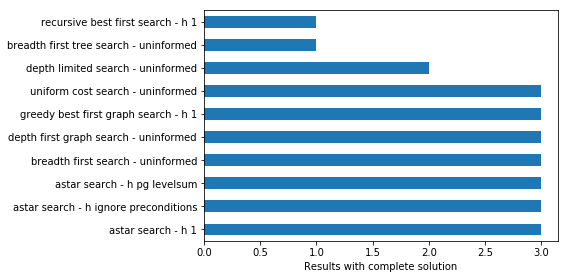

In [371]:
ax = complete.groupby('search').sum().sort_values('complete', ascending=False)['complete'].plot(kind='barh')

ax.set_ylabel('')
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Results with complete solution')
plt.savefig('../reports/figures/complete-search.png')

## Optimality

In [372]:
BEST = {'1': 6, '2': 9, '3': 12}

def is_optimal(row):
    return row['plan_length'] == BEST[row['problem']]


optimal = df[['problem', 'search', 'plan_length', 'plan']].copy()
optimal['optimal'] = optimal.apply(lambda r: 1 if is_optimal(r) else 0, axis=1)

In [390]:
optimal.drop('plan', axis=1)

,problem,search,plan_length,optimal
12,1,greedy best first graph search - h 1,6,1
14,1,astar search - h 1,6,1
24,1,recursive best first search - h 1,6,1
19,1,astar search - h ignore preconditions,6,1
9,1,astar search - h pg levelsum,6,1
1,1,depth first graph search - uninformed,20,0
2,1,breadth first tree search - uninformed,6,1
11,1,depth limited search - uninformed,50,0
15,1,uniform cost search - uninformed,6,1
17,1,breadth first search - uninformed,6,1


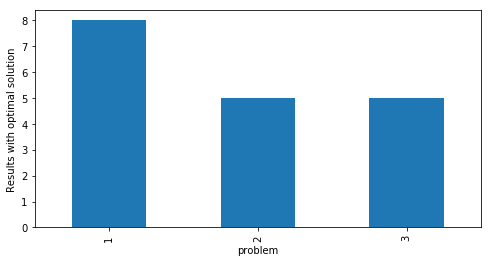

In [374]:
ax = optimal.groupby('problem').sum().sort_values('optimal', ascending=False)['optimal'].plot(kind='bar')

ax.set_ylabel('Results with optimal solution')
plt.savefig('../reports/figures/optimal-problem.png')

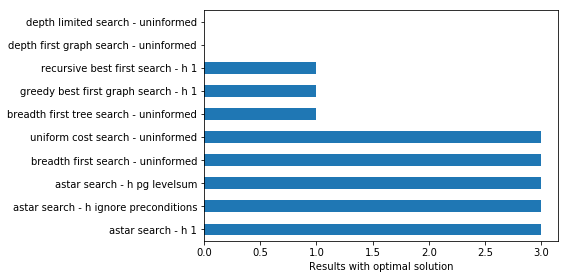

In [375]:
ax = optimal.groupby('search').sum().sort_values('optimal', ascending=False)['optimal'].plot(kind='barh')

ax.set_ylabel('')
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Results with optimal solution')
plt.savefig('../reports/figures/optimal-search.png')

## Time complexity

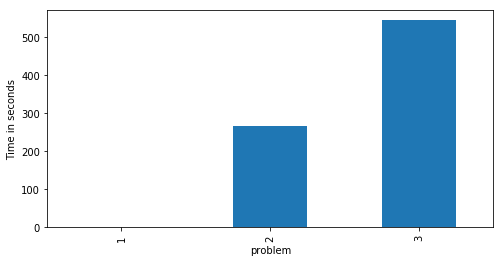

In [376]:
ax = df.groupby('problem').mean()['runtime'].sort_values().plot(kind='bar')

ax.set_ylabel('Time in seconds')
plt.savefig('../reports/figures/time-problem.png')

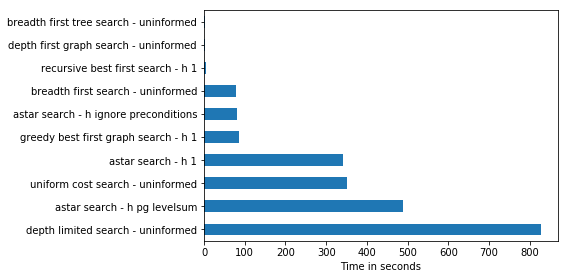

In [377]:
ax = df.groupby('search').mean()['runtime'].sort_values(ascending=False).plot(kind='barh')

ax.set_ylabel('')
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Time in seconds')
plt.savefig('../reports/figures/time-search.png')

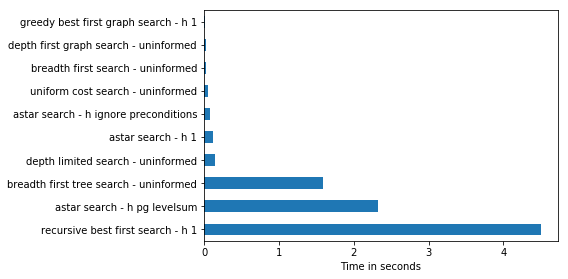

In [378]:
ax = df[df['problem'] == '1'].sort_values('runtime', ascending=False).plot(x='search', y='runtime', kind='barh')

ax.set_ylabel('')
ax.legend_.remove()
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Time in seconds')
plt.savefig('../reports/figures/time-p1.png')

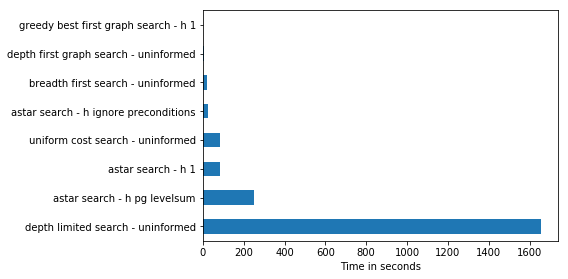

In [379]:
ax = df[df['problem'] == '2'].sort_values('runtime', ascending=False).plot(x='search', y='runtime', kind='barh')

ax.set_ylabel('')
ax.legend_.remove()
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Time in seconds')
plt.savefig('../reports/figures/time-p2.png')

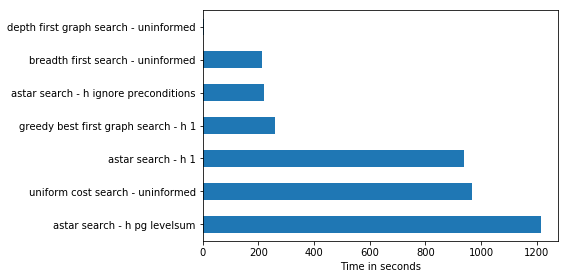

In [380]:
ax = df[df['problem'] == '3'].sort_values('runtime', ascending=False).plot(x='search', y='runtime', kind='barh')

ax.set_ylabel('')
ax.legend_.remove()
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Time in seconds')
plt.savefig('../reports/figures/time-p3.png')

## Space Complexity

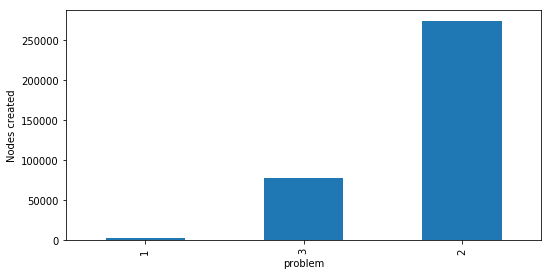

In [381]:
ax = df.groupby('problem').mean()['new_nodes'].sort_values().plot(kind='bar')

ax.set_ylabel('')
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
ax.set_ylabel('Nodes created')
plt.savefig('../reports/figures/space-problem.png')

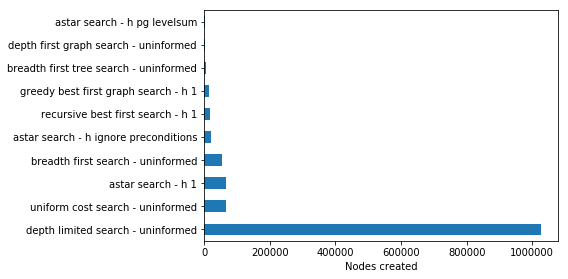

In [382]:
ax = df.groupby('search').mean()['new_nodes'].sort_values(ascending=False).plot(x='problem', y='new_nodes', kind='barh')

ax.set_ylabel('')
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Nodes created')
plt.savefig('../reports/figures/space-search.png')

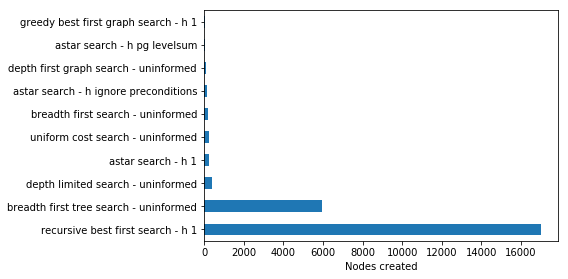

In [383]:
ax = df[df['problem'] == '1'].sort_values('new_nodes', ascending=False).plot(x='search', y='new_nodes', kind='barh')

ax.set_ylabel('')
plt.tight_layout()
ax.legend_.remove()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Nodes created')
plt.savefig('../reports/figures/space-p1.png')

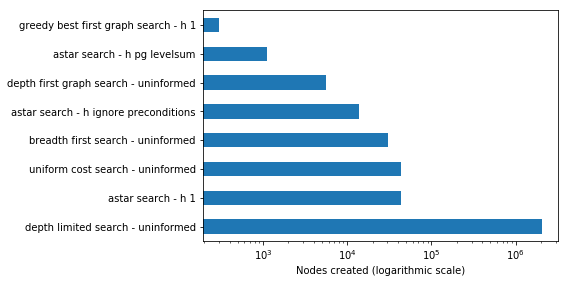

In [393]:
ax = df[df['problem'] == '2'].sort_values('new_nodes', ascending=False).plot(x='search', y='new_nodes', logx=True, kind='barh')

ax.set_ylabel('')
plt.tight_layout()
ax.legend_.remove()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Nodes created (logarithmic scale)')
plt.savefig('../reports/figures/space-p2.png')

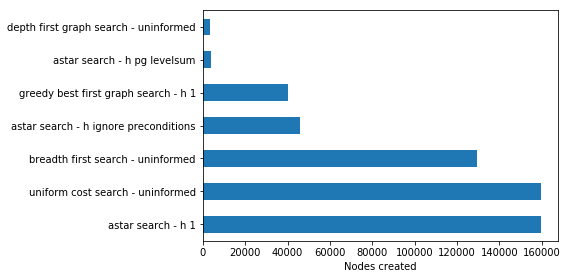

In [385]:
ax = df[df['problem'] == '3'].sort_values('new_nodes', ascending=False).plot(x='search', y='new_nodes', kind='barh')

ax.set_ylabel('')
plt.tight_layout()
ax.legend_.remove()
plt.gcf().subplots_adjust(bottom=0.15)
ax.set_xlabel('Nodes created')
plt.savefig('../reports/figures/space-p3.png')

In [394]:
df[df['runtime']>]

,problem,search,algorithm,heuristic,plan_length,new_nodes,runtime,plan
13,2,depth limited search - uninformed,depth_limited_search,uninformed,50,2054119,1656.404348,"[Load(C1, P1, SFO), Load(C2, P2, JFK), Load(C3..."
21,3,astar search - h 1,astar_search,h_1,12,159726,939.075264,"[Load(C1, P1, SFO), Fly(P1, SFO, ATL), Load(C2..."
8,3,astar search - h pg levelsum,astar_search,h_pg_levelsum,12,3724,1216.337195,"[Load(C2, P2, JFK), Fly(P2, JFK, ORD), Load(C4..."
3,3,uniform cost search - uninformed,uniform_cost_search,uninformed,12,159726,966.414331,"[Load(C1, P1, SFO), Fly(P1, SFO, ATL), Load(C2..."


# Appendix

## Optimal plans

In [386]:
for problem, group in optimal[optimal['optimal']==1].groupby('problem'):
    
    plans = {'\n'.join(plan) for plan in group['plan']}
    print("### Problem: {} (#plans = {}) ###".format(problem, len(plans)))
    print()
    
    for i, plan in enumerate(plans, 1):
        print("- Plan: {}".format(i))
        print(plan)
        print()

### Problem: 1 (#plans = 5) ###

- Plan: 1
Load(C1, P1, SFO)
Load(C2, P2, JFK)
Fly(P2, JFK, SFO)
Unload(C2, P2, SFO)
Fly(P1, SFO, JFK)
Unload(C1, P1, JFK)

- Plan: 2
Load(C2, P2, JFK)
Load(C1, P1, SFO)
Fly(P2, JFK, SFO)
Unload(C2, P2, SFO)
Fly(P1, SFO, JFK)
Unload(C1, P1, JFK)

- Plan: 3
Load(C1, P1, SFO)
Fly(P1, SFO, JFK)
Load(C2, P2, JFK)
Fly(P2, JFK, SFO)
Unload(C1, P1, JFK)
Unload(C2, P2, SFO)

- Plan: 4
Load(C1, P1, SFO)
Fly(P1, SFO, JFK)
Unload(C1, P1, JFK)
Load(C2, P2, JFK)
Fly(P2, JFK, SFO)
Unload(C2, P2, SFO)

- Plan: 5
Load(C1, P1, SFO)
Load(C2, P2, JFK)
Fly(P1, SFO, JFK)
Fly(P2, JFK, SFO)
Unload(C1, P1, JFK)
Unload(C2, P2, SFO)

### Problem: 2 (#plans = 3) ###

- Plan: 1
Load(C1, P1, SFO)
Fly(P1, SFO, JFK)
Load(C2, P2, JFK)
Fly(P2, JFK, SFO)
Load(C3, P3, ATL)
Fly(P3, ATL, SFO)
Unload(C3, P3, SFO)
Unload(C2, P2, SFO)
Unload(C1, P1, JFK)

- Plan: 2
Load(C1, P1, SFO)
Load(C2, P2, JFK)
Load(C3, P3, ATL)
Fly(P2, JFK, SFO)
Unload(C2, P2, SFO)
Fly(P1, SFO, JFK)
Unload(C1, P1, JFK)
